In [1]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import sklearn.model_selection as skm

from sklearn.model_selection import train_test_split
from statsmodels.datasets import get_rdataset
from ISLP import load_data, confusion_table
from ISLP.bart import BART
from ISLP.models import ModelSpec as MS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.tree import DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestRegressor as RF, GradientBoostingRegressor as GBR, GradientBoostingClassifier as GBC, RandomForestClassifier
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

%matplotlib inline

### Exercise 8.4.7

In section 8.3.3, we applied random forests to the `Boston` data using `max_features = 6` and using `n_estimators = 100` and `n_estimators = 500`. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for `max_features` and `n_estimators`. You can model your plot after Figure 8.10. Describe the results obtained.

__Answer__:

- the optimal number of trees is around 200, because an increasing number of trees does not improve test MSE and the Random Forest in this case slightly overfits to a data,
- with an increasing number of feautres, random forests grasp more information and hence it produces lower test MSE.

In [2]:
boston = load_data('Boston')
model = MS(boston.columns.drop('medv'), intercept=False)
D = model.fit_transform(boston)
feature_names = list(D.columns)
X = np.asarray(D)

X_train, X_test, y_train, y_test = skm.train_test_split(X, boston['medv'], test_size=0.3, random_state=0)

In [3]:
n_estimators = np.arange(50, 1050, 50)
max_features = np.arange(1, X_train.shape[1] + 1) 

test_errors = []
for n_estimator in n_estimators:
    for max_feature in max_features:

        random_forest = RF(max_features=max_feature, random_state=0, n_estimators=n_estimator)
        random_forest.fit(X_train, y_train)

        y_hat_pred = random_forest.predict(X_test)

        mse = np.mean(np.square(y_test - y_hat_pred))
        test_errors.append({'test_mse': mse, 'n_estimators': n_estimator, 'max_features': max_feature})

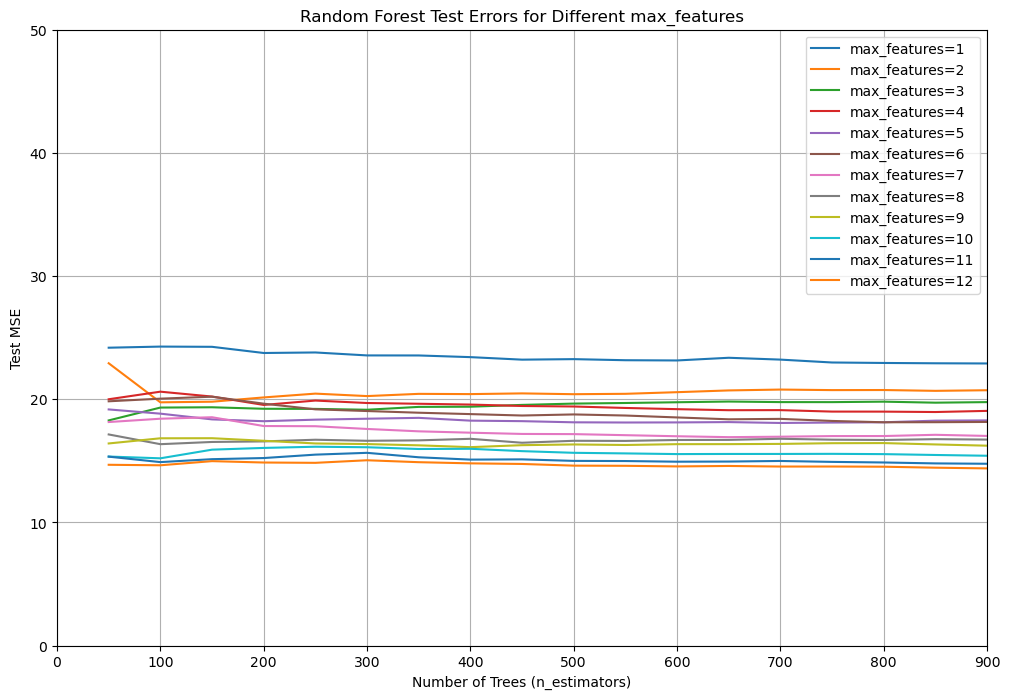

In [4]:
max_features_values = np.unique([item['max_features'] for item in test_errors])

plt.figure(figsize=(12, 8))
for max_feature in max_features_values:
    subset = [item for item in test_errors if item['max_features'] == max_feature]

    n_estimators_values = [item['n_estimators'] for item in subset]
    test_mse_values = [item['test_mse'] for item in subset]
    
    plt.plot(n_estimators_values, test_mse_values, label=f'max_features={max_feature}')

plt.xlabel('Number of Trees (n_estimators)')
plt.ylabel('Test MSE')
plt.title('Random Forest Test Errors for Different max_features')
plt.legend()
plt.grid(True)

plt.xlim(0, 900)  
plt.ylim(0, 50) 

plt.show()

### Exercise 8.4.8

In the lab, classification tree  was applied to the `Carseats` data set after converting `Sales` into a qualitative response variable. Now we will seek to predict `Sales` using regression trees and related approaches, treating the response as a quantitative variable.

In [5]:
carseats = load_data('Carseats')
model = MS(carseats.columns.drop(['Sales']), intercept=False)
D = model.fit_transform(carseats)
feature_names = list(D.columns)
X = np.asarray(D)

#### Exercise 8.4.8 (a)

Split the data set into a training set and a test set.


In [6]:
X_train, X_test, y_train, y_test = skm.train_test_split(X, carseats['Sales'], test_size=0.3, random_state=0)

#### Exercise 8.4.8 (b)

Fit a regression tree to the training set. Plot the tree, and intrepret the results. What test MSE do you obtain?

__Answer__:

- based on the tree structure, the most important feature is `ShelveLoc`, which splits between 0.5,
- another contributable predictors are `Price` and `Age`.


In [7]:
regressor = DTR(random_state=0)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(random_state=0)

In [8]:
y_hat = regressor.predict(X_test)
test_mse = np.mean(np.square(y_test - y_hat))
test_mse

5.083071666666667

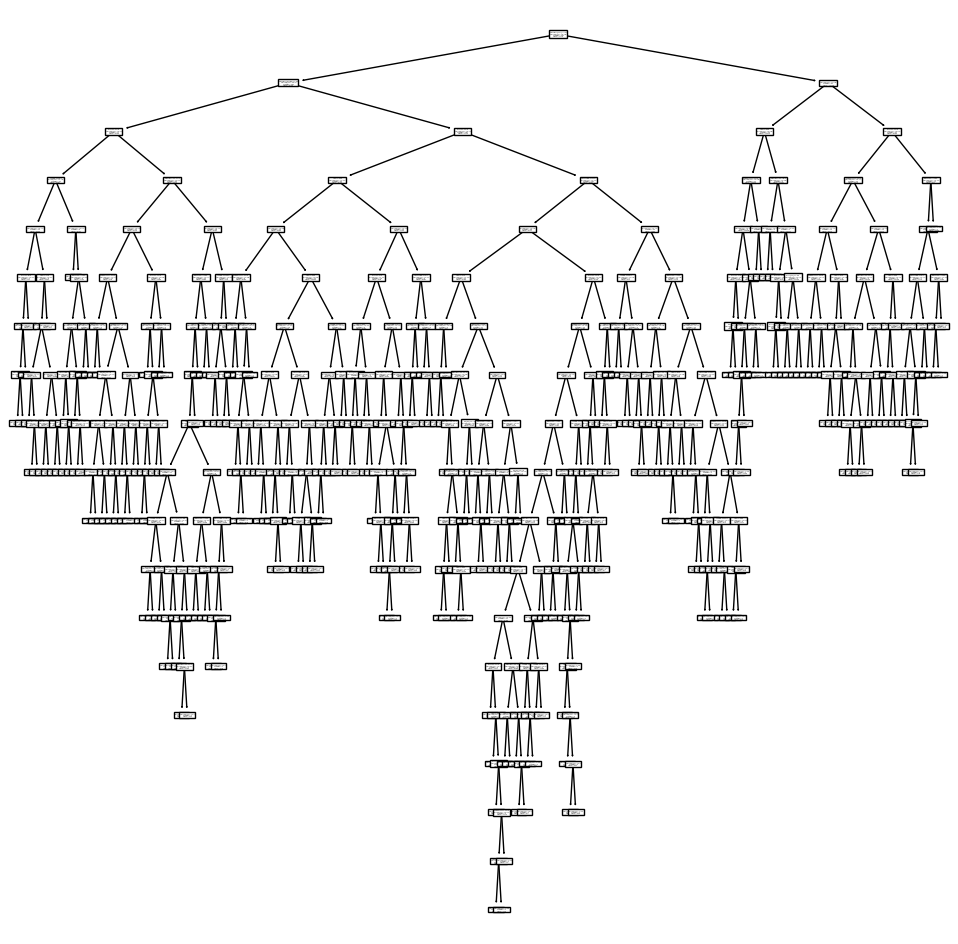

In [9]:
ax = plt.subplots(figsize =(12 ,12))[1]
plot_tree(regressor, feature_names=feature_names, ax=ax);

#### Exercise 8.4.8 (c)

Use cross-validation in order to determine the optimal level of tree complexity. Does pruning improve the test MSE?

__Answer__:

- Cost Complexity Pruning did improve a test MSE, resulting in simpler subtree, however it might still overfit to a data.

In [10]:
ccp_alphas = np.linspace(0, 1, 100)
scores = []
dtree = DTR(random_state=0)
for alpha in ccp_alphas:
    dtree.set_params(ccp_alpha=alpha)
    cv_scores = cross_val_score(dtree, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    scores.append(np.mean(-cv_scores))

optimal_alpha = ccp_alphas[np.argmin(scores)]
print("Optimal ccp_alpha:", optimal_alpha)


Optimal ccp_alpha: 0.04040404040404041


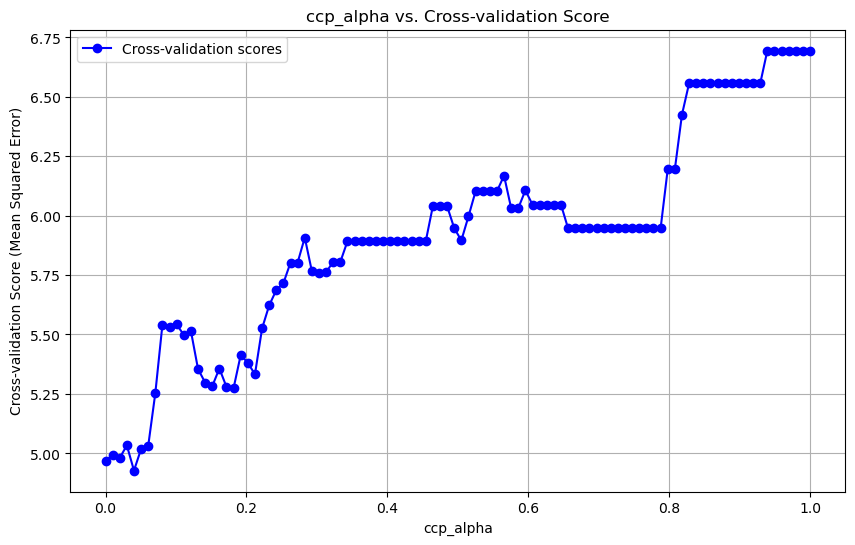

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, scores, marker='o', linestyle='-', color='b', label='Cross-validation scores')
plt.xlabel('ccp_alpha')
plt.ylabel('Cross-validation Score (Mean Squared Error)')
plt.title('ccp_alpha vs. Cross-validation Score')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
final_dtree = DTR(ccp_alpha=optimal_alpha, random_state=0)
final_dtree.fit(X_train, y_train)
y_hat = final_dtree.predict(X_test)
test_mse = np.mean(np.square(y_test - y_hat))
test_mse

4.299515414299601

#### Exercise 8.4.8 (d)

Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the `feature_importance_` values to determine which variables are most important.

__Answer__:

- `feature_importance_` indicates that the most important features are: `Price`, `ShelveLoc`, `Age`.

In [13]:
from sklearn.ensemble import BaggingRegressor


base_dtree = DTR(random_state=0)
bagging_model = BaggingRegressor(base_dtree, n_estimators=100, random_state=0)
cv_scores_bagging = cross_val_score(bagging_model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print("Mean Cross-validation Score (Bagging):", np.mean(-cv_scores_bagging))

bagging_model.fit(X_train, y_train)
y_hat = bagging_model.predict(X_test)
print(f'Test MSE: {np.mean(np.square(y_test - y_hat))}')

Mean Cross-validation Score (Bagging): 2.6509060439642855
Test MSE: 2.038309439500001


In [14]:
feature_importances = np.zeros(X_train.shape[1])
for tree in bagging_model.estimators_:
    feature_importances += tree.feature_importances_

feature_importances /= bagging_model.n_estimators
print("Feature Importances (Bagging):", feature_importances)

feature_imp = pd.DataFrame({'importance':feature_importances}, index=feature_names)
feature_imp.sort_values(by='importance', ascending=False)

Feature Importances (Bagging): [0.09795958 0.05271361 0.07427921 0.04114729 0.27815341 0.22241673
 0.0827448  0.10766343 0.03135226 0.00506392 0.00650575]


,importance
Price,0.278153
ShelveLoc[Good],0.222417
Age,0.107663
CompPrice,0.097960
ShelveLoc[Medium],0.082745
Advertising,0.074279
Income,0.052714
Population,0.041147
Education,0.031352
US[Yes],0.006506


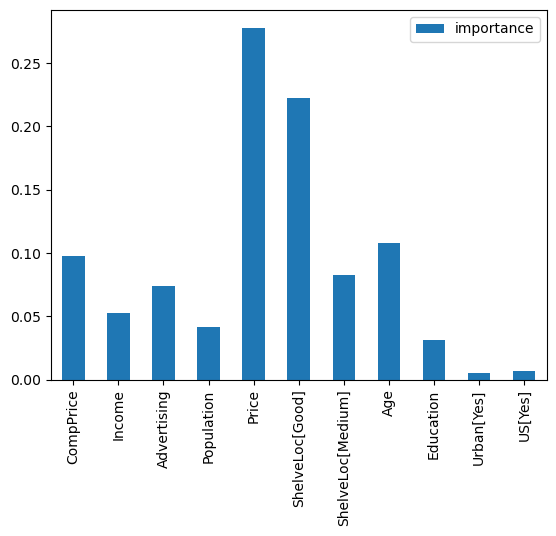

In [15]:
feature_imp.plot(kind='bar');

#### Exercise 8.4.8 (e) 

Use random forests to analyze this data. What test MSE do you obtain? Use the `feature_importance_` values to determine which variables are most important. Describe the effect of *m*, the number of variables considered at each split, on the error rate obtained.

- in this case, the effect of *m* would indicate that the more variables were chosen to split, the less test MSE, so increasing $m$ did improve test MSE.

In [16]:
max_features_values = ['sqrt', 'log2'] + list(range(1, X_train.shape[1] + 1))
test_mse_values = []
for max_features in max_features_values:
    rf_model = RF(n_estimators=500, max_features=max_features, random_state=0)
    rf_model.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)

    test_mse = np.mean(np.square(y_test - y_pred))
    print(f"Test MSE (max_features={max_features}): {test_mse}")
    test_mse_values.append(test_mse)
    feature_importances = rf_model.feature_importances_
    print(f"Feature Importances (max_features={max_features}):", feature_importances)
    print("-" * 50)

Test MSE (max_features=sqrt): 2.312642236786674
Feature Importances (max_features=sqrt): [0.09634865 0.08660686 0.08943714 0.07569071 0.2438067  0.15897734
 0.04694999 0.12187361 0.05022134 0.01265806 0.0174296 ]
--------------------------------------------------
Test MSE (max_features=log2): 2.312642236786674
Feature Importances (max_features=log2): [0.09634865 0.08660686 0.08943714 0.07569071 0.2438067  0.15897734
 0.04694999 0.12187361 0.05022134 0.01265806 0.0174296 ]
--------------------------------------------------
Test MSE (max_features=1): 3.1869207534608393
Feature Importances (max_features=1): [0.10552858 0.10630236 0.08932707 0.10727026 0.19243702 0.11970827
 0.03142856 0.12787632 0.07786873 0.0187452  0.02350764]
--------------------------------------------------
Test MSE (max_features=2): 2.6851495376233356
Feature Importances (max_features=2): [0.10005019 0.09522316 0.0878803  0.08930987 0.21726907 0.1411175
 0.0422643  0.12736677 0.06121821 0.016566   0.02173463]
------

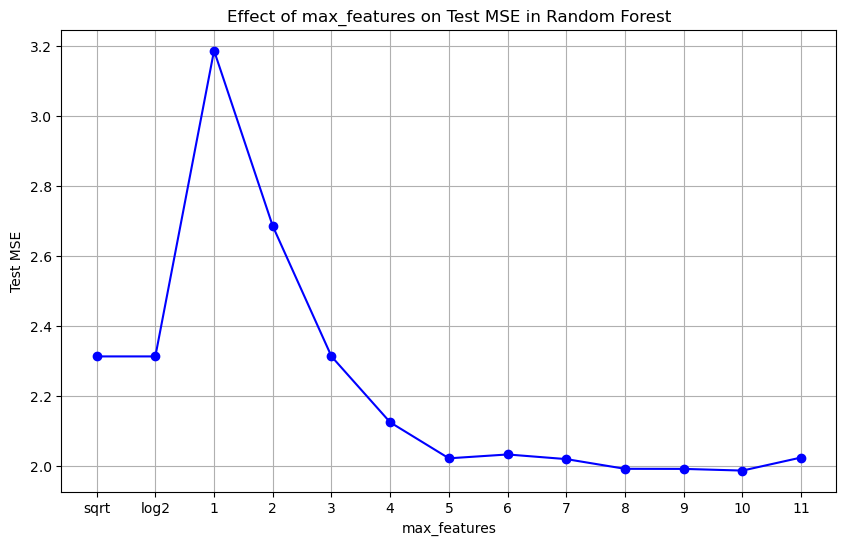

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(max_features_values, test_mse_values, marker='o', linestyle='-', color='b')
plt.xlabel('max_features')
plt.ylabel('Test MSE')
plt.title('Effect of max_features on Test MSE in Random Forest')
plt.grid(True)
plt.show()


#### Exercise 8.4.8 (f)

Now analyze the data using BART, and report your results.

In [18]:
bart_boston = BART(random_state=0, burnin=5, ndraw=15)
bart_boston.fit(X_train, y_train)

BART(burnin=5, ndraw=15, random_state=0)

In [19]:
yhat_test = bart_boston.predict(X_test.astype(np.float32))
np.mean((y_test - yhat_test) **2)

1.4830955913724182

In [20]:
var_inclusion = pd.Series(bart_boston.variable_inclusion_.mean(0), index=D.columns)
var_inclusion

CompPrice            31.200000
Income               23.933333
Advertising          28.933333
Population           22.266667
Price                37.000000
ShelveLoc[Good]      31.466667
ShelveLoc[Medium]    28.933333
Age                  28.666667
Education            23.666667
Urban[Yes]           24.533333
US[Yes]              27.200000
dtype: float64

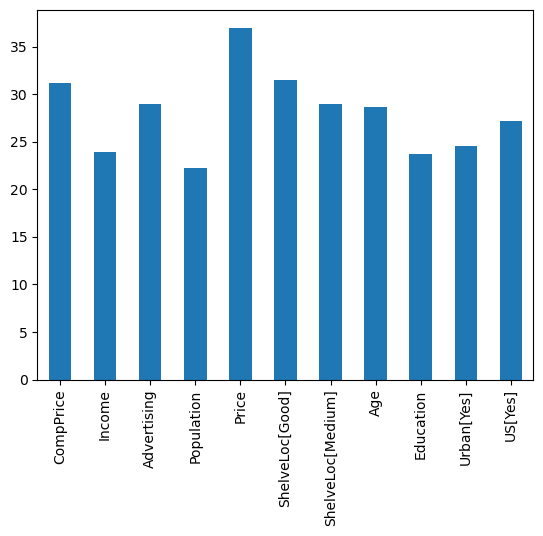

In [21]:
var_inclusion.plot(kind='bar');

### Exercise 8.4.9 

This problem involves the `OJ` data set which is part of the `ISLP` package.



#### Exercise 8.4.9 (a)

Create a training set containing a random sample of 800 observations, and a test set containing the remaining observations. 

In [22]:
oj_data = load_data('OJ')

In [23]:
df_shuffle = oj_data.sample(frac=1, random_state=0)
df_shuffle.head()

,Purchase,WeekofPurchase,StoreID,PriceCH,PriceMM,DiscCH,DiscMM,SpecialCH,SpecialMM,LoyalCH,SalePriceMM,SalePriceCH,PriceDiff,Store7,PctDiscMM,PctDiscCH,ListPriceDiff,STORE
928,MM,234,3,1.79,2.09,0.00,0.0,0,0,0.204800,2.09,1.79,0.30,No,0.000000,0.000000,0.30,3
780,CH,232,1,1.69,1.99,0.00,0.0,1,0,0.586313,1.99,1.69,0.30,No,0.000000,0.000000,0.30,1
564,CH,266,7,1.86,2.13,0.37,0.0,1,0,0.600000,2.13,1.49,0.64,Yes,0.000000,0.198925,0.27,0
520,CH,259,2,1.86,2.18,0.00,0.4,0,1,0.680000,1.78,1.86,-0.08,No,0.183486,0.000000,0.32,2
399,MM,271,7,1.86,2.13,0.00,0.0,0,0,0.429471,2.13,1.86,0.27,Yes,0.000000,0.000000,0.27,0


In [24]:
training_size = 800
X_train_shuff, y_train_shuff = df_shuffle.iloc[:training_size, 1:], df_shuffle.iloc[:training_size, 0]
X_test_shuff, y_test_shuff = df_shuffle.iloc[training_size:, 1:], df_shuffle.iloc[training_size:, 0]

In [25]:
lec = LabelEncoder()
X_train_shuff.Store7 = lec.fit_transform(X_train_shuff.Store7)
X_test_shuff.Store7 = lec.transform(X_test_shuff.Store7)

#### Exercise 8.4.9 (b)

Fit a tree to the training data, with `Purchase` as the response and the other variables as predictors. What is the training error rate?

In [26]:
unpruned_clf = DTC(max_leaf_nodes=20).fit(X_train_shuff, y_train_shuff)
y_hat = unpruned_clf.predict(X_test_shuff)

In [27]:
train_error_rate = 1 - unpruned_clf.score(X_train_shuff, y_train_shuff)
train_error_rate

0.12375000000000003

In [28]:
test_error_rate = 1 - unpruned_clf.score(X_test_shuff, y_test_shuff)
test_error_rate

0.18518518518518523

#### Exercise 8.4.9 (c)

Create a plot of the tree, and interpret the results. How many terminal nodes does the tree have?

__Answer__:
- based on the obtained tree, we see that predictor `LoyalCH` is the most important, because it reduces as much as possible impurity in that specific node (root),
- based on the split of the root, we also see different predictors that account to the split:<br>
    - for example: when `LoyalCH <= 0.482`, then the predictors are: `PriceDiff`, `STORE`, `SpecialCH`, `LoyalCH`,
    - On the right, when `LoyalCH > 0.482`, we see again important predictor like `PriceDiff`, but we also see `ListPriceDiff`.

In [29]:
unpruned_clf.tree_.n_leaves

20

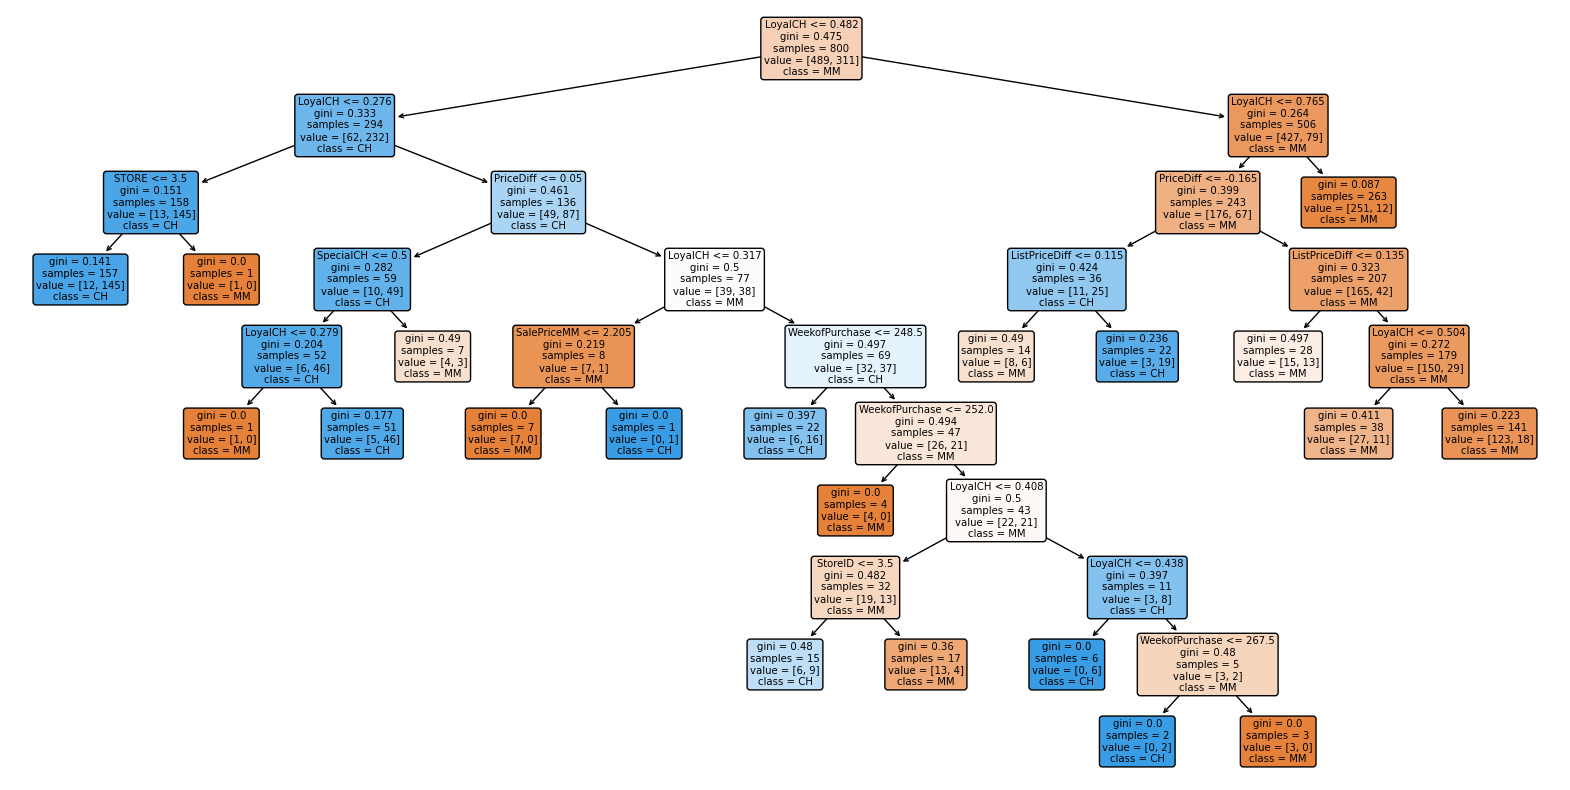

In [30]:
plt.figure(figsize=(20, 10))
plot_tree(unpruned_clf, feature_names=X_train_shuff.columns.tolist(), class_names=["MM", "CH"], filled=True, rounded=True);

#### Exercise 8.4.9 (d)

Use the `export_tree()` function to produce a text summary of the fitted tree. Pick one of the terminal nodes, and interpret the information displayed.

__Answer__:
- The leaf of the second split where `STORE <= 3.5`, we see that `gini` value is 0, meaning that node is totally pure.

In [31]:
print(export_text(unpruned_clf, feature_names=X_train_shuff.columns.tolist(), class_names=df_shuffle.Purchase.unique().tolist()))

|--- LoyalCH <= 0.48
|   |--- LoyalCH <= 0.28
|   |   |--- STORE <= 3.50
|   |   |   |--- class: CH
|   |   |--- STORE >  3.50
|   |   |   |--- class: MM
|   |--- LoyalCH >  0.28
|   |   |--- PriceDiff <= 0.05
|   |   |   |--- SpecialCH <= 0.50
|   |   |   |   |--- LoyalCH <= 0.28
|   |   |   |   |   |--- class: MM
|   |   |   |   |--- LoyalCH >  0.28
|   |   |   |   |   |--- class: CH
|   |   |   |--- SpecialCH >  0.50
|   |   |   |   |--- class: MM
|   |   |--- PriceDiff >  0.05
|   |   |   |--- LoyalCH <= 0.32
|   |   |   |   |--- SalePriceMM <= 2.21
|   |   |   |   |   |--- class: MM
|   |   |   |   |--- SalePriceMM >  2.21
|   |   |   |   |   |--- class: CH
|   |   |   |--- LoyalCH >  0.32
|   |   |   |   |--- WeekofPurchase <= 248.50
|   |   |   |   |   |--- class: CH
|   |   |   |   |--- WeekofPurchase >  248.50
|   |   |   |   |   |--- WeekofPurchase <= 252.00
|   |   |   |   |   |   |--- class: MM
|   |   |   |   |   |--- WeekofPurchase >  252.00
|   |   |   |   |   |   |--- L

#### Exercise 8.4.9 (e)

Predict the response on the test data, and produce a confusion matrix comparing the test labels to the predicted test labels. What is the test error rate?


In [32]:
test_error_rate = 1 - unpruned_clf.score(X_test_shuff, y_test_shuff)
test_error_rate

0.18518518518518523

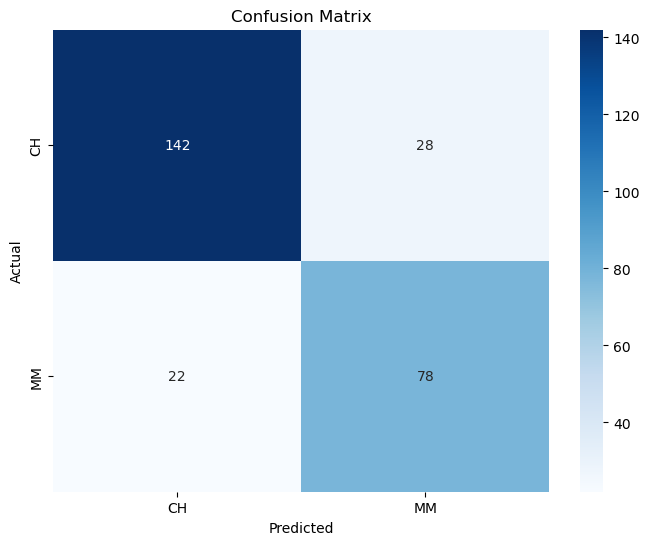

In [33]:
cm = confusion_matrix(y_hat, y_test_shuff)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(df_shuffle.Purchase), yticklabels=np.unique(df_shuffle.Purchase))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');


#### Exercise 8.4.9 (f)

Use cross-valdation on the training set in order to determine the optimal tree size.



In [34]:
ccp_alphas = np.linspace(0, 0.03, 20)


error_rates = []
tree_depths = []
for alpha in ccp_alphas:
    clf = DTC(ccp_alpha=alpha)
    clf.fit(X_train_shuff, y_train_shuff)
    scores = cross_val_score(clf, X_train_shuff, y_train_shuff, cv=10)  
    tree_depths.append(clf.tree_.max_depth)
    error_rate = 1 - np.mean(scores)
    error_rates.append(error_rate)

optimal_alpha = ccp_alphas[np.argmin(error_rates)]
final_model = DTC(ccp_alpha=optimal_alpha)
final_model.fit(X_train_shuff, y_train_shuff)

DecisionTreeClassifier(ccp_alpha=0.020526315789473684)

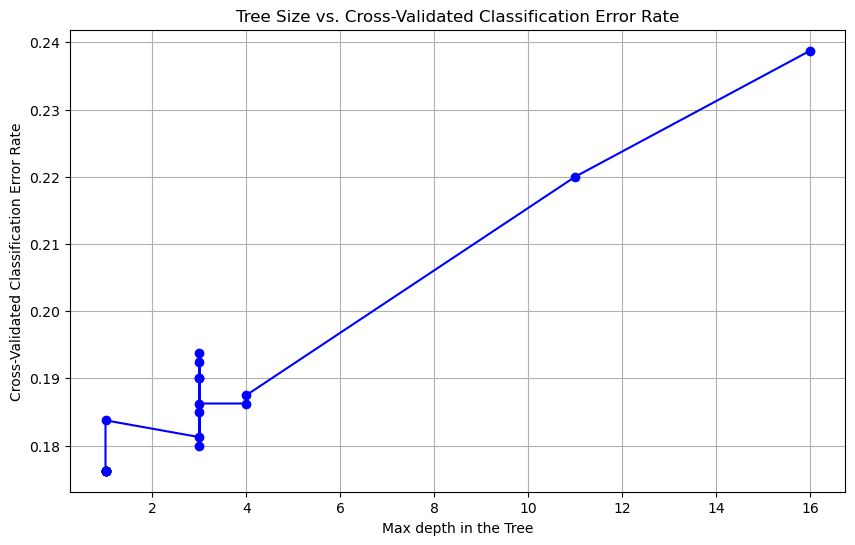

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(tree_depths, error_rates, marker='o', linestyle='-', color='b')
plt.title('Tree Size vs. Cross-Validated Classification Error Rate')
plt.xlabel('Max depth in the Tree')
plt.ylabel('Cross-Validated Classification Error Rate')
plt.grid(True)
plt.show()

#### Exercise 8.4.9 (h)

Which tree size corresponds to the lowest cross-validated classification error rate?

__Answer__:

- Considering paramter `max_depth` as a tree size factor, then the lowest cross-validated erro rate is the tree with size 1.

#### Exercise 8.4.9 (i)

Produce a pruned tree corresponding to the optimal tree size obtained using cross-validation. If cross-validation does not lead
to selection of a pruned tree, then create a pruned tree with five terminal nodes.

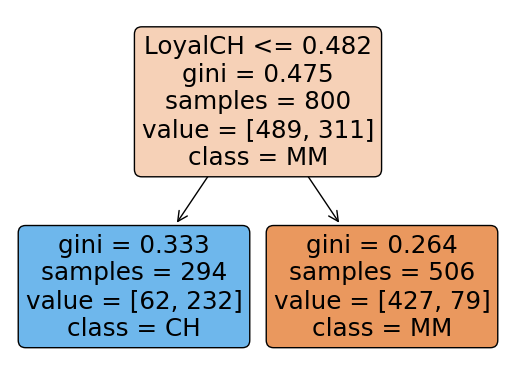

In [36]:
plot_tree(final_model, feature_names=X_train_shuff.columns.to_list(), class_names=df_shuffle.Purchase.unique().tolist(), rounded=True, filled=True);

#### Exercise 8.4.9 (h)

Compare the training error rates between the pruned and unpruned trees. Which is higher?

__Answer__:

- the training error is higher for pruned tree, since we get rid of a variance at the cost of increasing a bias, it is expected.

In [37]:
pruned_err_rate = 1 - final_model.score(X_train_shuff, y_train_shuff)
unpruned_err_rate = 1 - unpruned_clf.score(X_train_shuff, y_train_shuff)

print(f'Pruned tree train error rate: {pruned_err_rate}\nUnpruned tree train error rate: {unpruned_err_rate}')

Pruned tree train error rate: 0.17625000000000002
Unpruned tree train error rate: 0.12375000000000003


#### Exercise 8.4.9 (k)

Compare the test error rates between the pruned and unpruned trees. Which is higher?

__Answer__:
- the test error rate is higher also for pruned tree, however, comparing the size of pruned vs. unpruned tree, the pruned error rate does not deviate a lot from a unpruned tree.  

In [38]:
pruned_err_rate = 1 - final_model.score(X_test_shuff, y_test_shuff)
unpruned_err_rate = 1 - unpruned_clf.score(X_test_shuff, y_test_shuff)

print(f'Pruned tree test error rate: {pruned_err_rate}\nUnpruned tree test error rate: {unpruned_err_rate}')

Pruned tree test error rate: 0.23333333333333328
Unpruned tree test error rate: 0.18518518518518523


### Exercise 8.4.10

We now use boosting to predict `Salary` in the `Hitters` data set.

In [39]:
hitters = load_data("Hitters")

#### Exercise 8.4.10 (a)

Remove the observations for whom the salary information is unknown, and then log-transform the salaries.

In [40]:
hitters_without_na_salary = hitters[~hitters.Salary.isna()]
hitters_without_na_salary['log_Salary'] = hitters_without_na_salary.loc[:, 'Salary'].map(lambda row: np.log(row))

#### Exercise 8.4.10 (b)

Create a training set consisting of the first 200 observations, and a test set consisting of the remaining observations.

In [41]:
hitters_shuff = hitters_without_na_salary.sample(frac=1, random_state=0)
y_train_hitters = hitters_shuff.iloc[:200, -1]
X_train_hitters = hitters_shuff[hitters_shuff.columns.drop(["Salary", "log_Salary"])][:200]

y_test_hitters = hitters_shuff.iloc[200:, -1]
X_test_hitters = hitters_shuff[hitters_shuff.columns.drop(["Salary", "log_Salary"])][200:]

lec = LabelEncoder()
X_train_hitters.League = lec.fit_transform(X_train_hitters.League)
X_test_hitters.League = lec.transform(X_test_hitters.League)

lec = LabelEncoder()
X_train_hitters.Division = lec.fit_transform(X_train_hitters.Division)
X_test_hitters.Division = lec.transform(X_test_hitters.Division)

lec = LabelEncoder()
X_train_hitters.NewLeague = lec.fit_transform(X_train_hitters.NewLeague)
X_test_hitters.NewLeague = lec.transform(X_test_hitters.NewLeague)

#### Exercise 8.4.10 (c)

Perform boosting on the training set with $1000$ trees for a range of values of the shrinkage parameter $\lambda$. Produce a plot with different shrinkage parameter values on the $x$-axis and the corresponding training set $\text{MSE}$ on the $y$-axis.

In [42]:
start_rate = 1e-6
end_rate = 1
num_rates = 50
learning_rates = np.logspace(np.log10(start_rate), np.log10(end_rate), num=num_rates)
train_mse_values = []
test_mse_values = []

for lr in learning_rates:
    model = GBR(n_estimators=1000, max_depth=5, random_state=0, learning_rate=lr)
    model.fit(X_train_hitters, y_train_hitters)

    y_train_pred = model.predict(X_train_hitters)

    train_mse = np.mean(np.square(y_train_hitters - y_train_pred))
    train_mse_values.append(train_mse)

    y_test_pred = model.predict(X_test_hitters)
    test_mse = np.mean(np.square(y_test_hitters - y_test_pred))
    test_mse_values.append(test_mse)


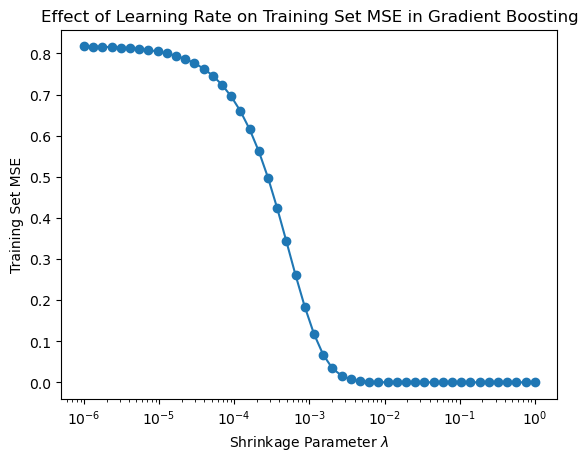

In [43]:
plt.plot(learning_rates, train_mse_values, marker='o')
plt.xscale('log')
plt.xlabel('Shrinkage Parameter $\lambda$')
plt.ylabel('Training Set MSE')
plt.title('Effect of Learning Rate on Training Set MSE in Gradient Boosting')
plt.show()

#### Exercise 8.4.10 (d)

Produce a plot with different shrinkage values on the $x$-axis and the corresponding test set MSE on the $y$-axis.

In [44]:
start_rate = 1e-7
end_rate = 1.5
num_rates = 50
learning_rates = np.logspace(np.log10(start_rate), np.log10(end_rate), num=num_rates)
train_mse_values = []
test_mse_values = []

for lr in learning_rates:
    model = GBR(n_estimators=1000, max_depth=5, random_state=0, learning_rate=lr)
    model.fit(X_train_hitters, y_train_hitters)

    y_train_pred = model.predict(X_train_hitters)

    train_mse = np.mean(np.square(y_train_hitters - y_train_pred))
    train_mse_values.append(train_mse)

    y_test_pred = model.predict(X_test_hitters)
    test_mse = np.mean(np.square(y_test_hitters - y_test_pred))
    test_mse_values.append(test_mse)


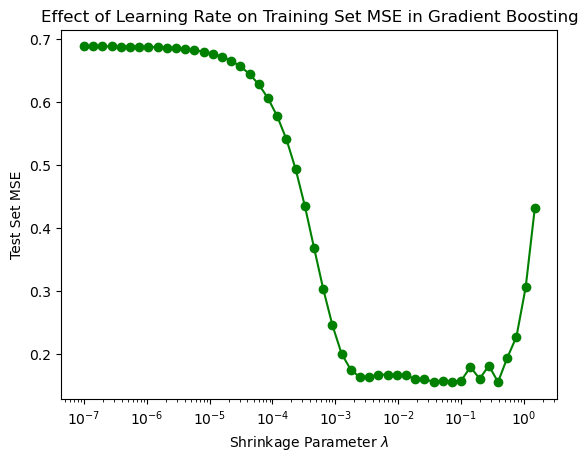

In [45]:
plt.plot(learning_rates, test_mse_values, marker='o', color='green')
plt.xscale('log')
plt.xlabel('Shrinkage Parameter $\lambda$')
plt.ylabel('Test Set MSE')
plt.title('Effect of Learning Rate on Training Set MSE in Gradient Boosting')
plt.show()

#### Exercise 8.4.10 (e)

Comparet the test MSE of boosting to the test MSE that results from applying two of the regression approaches seen in chapters 3 and 6.

Results:
- while comparing boosting test MSE, for specified shrinkage parameter $\lambda$ range of values around 0.0001-0.001 we have lower test MSE compared to unregularized Multiple Linear Regression model,
- Ridge Regression at $k = 10$ K-Fold Cross Validation, with specific alpha $\alpha = 37.92$ achieves a slightly worse score than multiple linear regression;

In [46]:
mlr = LinearRegression()
mlr.fit(X_train_hitters, y_train_hitters)
y_hat = mlr.predict(X_test_hitters)
np.mean(np.square(y_test_hitters - y_hat))

0.37897882054000454

In [47]:
scaler = StandardScaler()
X_train_hitters_std = scaler.fit_transform(X_train_hitters)
X_test_hitters_std = scaler.transform(X_test_hitters)

In [48]:
alphas = np.logspace(-6, 6, 20)
ridge = RidgeCV(alphas=alphas, scoring='neg_mean_squared_error', cv=10)
ridge.fit(X_train_hitters_std, y_train_hitters)

RidgeCV(alphas=array([1.00000000e-06, 4.28133240e-06, 1.83298071e-05, 7.84759970e-05,
       3.35981829e-04, 1.43844989e-03, 6.15848211e-03, 2.63665090e-02,
       1.12883789e-01, 4.83293024e-01, 2.06913808e+00, 8.85866790e+00,
       3.79269019e+01, 1.62377674e+02, 6.95192796e+02, 2.97635144e+03,
       1.27427499e+04, 5.45559478e+04, 2.33572147e+05, 1.00000000e+06]),
        cv=10, scoring='neg_mean_squared_error')

In [49]:
-ridge.best_score_

0.4168088312917588

In [50]:
ridge.alpha_

37.92690190732246

In [51]:
ridge_y_hat = ridge.predict(X_test_hitters_std)
np.mean(np.square(y_test_hitters - ridge_y_hat))

0.38395352700427376

In [52]:
lasso = LassoCV(alphas=alphas, random_state=0, max_iter=1000)
lasso.fit(X_train_hitters_std, y_train_hitters)

LassoCV(alphas=array([1.00000000e-06, 4.28133240e-06, 1.83298071e-05, 7.84759970e-05,
       3.35981829e-04, 1.43844989e-03, 6.15848211e-03, 2.63665090e-02,
       1.12883789e-01, 4.83293024e-01, 2.06913808e+00, 8.85866790e+00,
       3.79269019e+01, 1.62377674e+02, 6.95192796e+02, 2.97635144e+03,
       1.27427499e+04, 5.45559478e+04, 2.33572147e+05, 1.00000000e+06]),
        random_state=0)

In [53]:
np.mean(lasso.mse_path_)

0.6635311369827144

In [54]:
lasso.alpha_

0.026366508987303555

In [55]:
lasso_y_hat = lasso.predict(X_test_hitters_std)
np.mean(np.square(y_test_hitters - lasso_y_hat))

0.3829291491860377

#### Exercise 8.4.10 (f)

Which variables appear to be the most important predictors in the boosted model?

In [56]:
model = GBR(n_estimators=1000, max_depth=5, random_state=0, learning_rate=0.002)
model.fit(X_train_hitters, y_train_hitters)

GradientBoostingRegressor(learning_rate=0.002, max_depth=5, n_estimators=1000,
                          random_state=0)

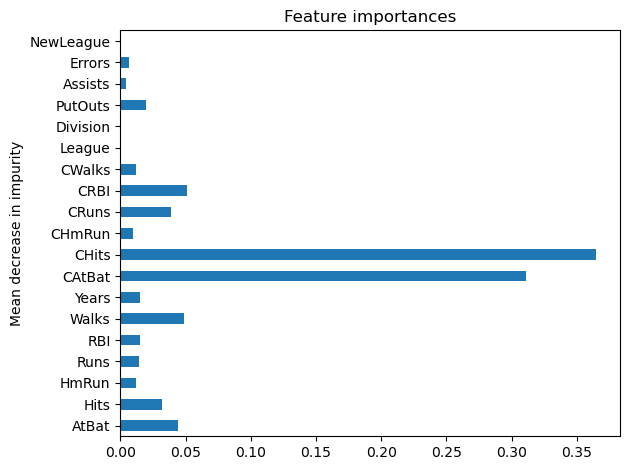

In [57]:
feature_importances = pd.Series(model.feature_importances_, index=X_train_hitters.columns)
fig, ax = plt.subplots()
feature_importances.plot.barh()
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout();

#### Exercise 8.4.10 (g)

Now apply bagging to the training set. What is the test set MSE for this approach?

In [58]:
base_model = DTR(max_depth=5, random_state=0)
bagging_model = BaggingRegressor(base_estimator=base_model, n_estimators=10, random_state=0)

In [59]:
bagging_model.fit(X_train_hitters, y_train_hitters)
y_hat = bagging_model.predict(X_test_hitters)
np.mean(np.square(y_test_hitters - y_hat))

0.13661915002083194

### Exercise 8.4.11 

This question uses the `Caravan` data set.

In [60]:
caravan_data = load_data('Caravan')

#### Exercise 8.4.11 (a)

Create a training set, consisting of the first $1000$ observations, and a test set consisting of the remaining observations.

In [61]:
caravan_shuff = caravan_data.sample(frac=1.0, random_state=0)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(caravan_shuff['Purchase'])
caravan_shuff['y_enc'] = y_encoded
X_train_carav, y_train_carav = caravan_shuff[caravan_shuff.columns.drop(['Purchase', 'y_enc'])].iloc[:1000], caravan_shuff['y_enc'].iloc[:1000]
X_test_carav, y_test_carav = caravan_shuff[caravan_shuff.columns.drop(['Purchase', 'y_enc'])].iloc[1000:], caravan_shuff['y_enc'].iloc[1000:]

In [62]:
boosted_model = GBC(n_estimators=1000, learning_rate=0.01)
boosted_model.fit(X_train_carav, y_train_carav)

GradientBoostingClassifier(learning_rate=0.01, n_estimators=1000)

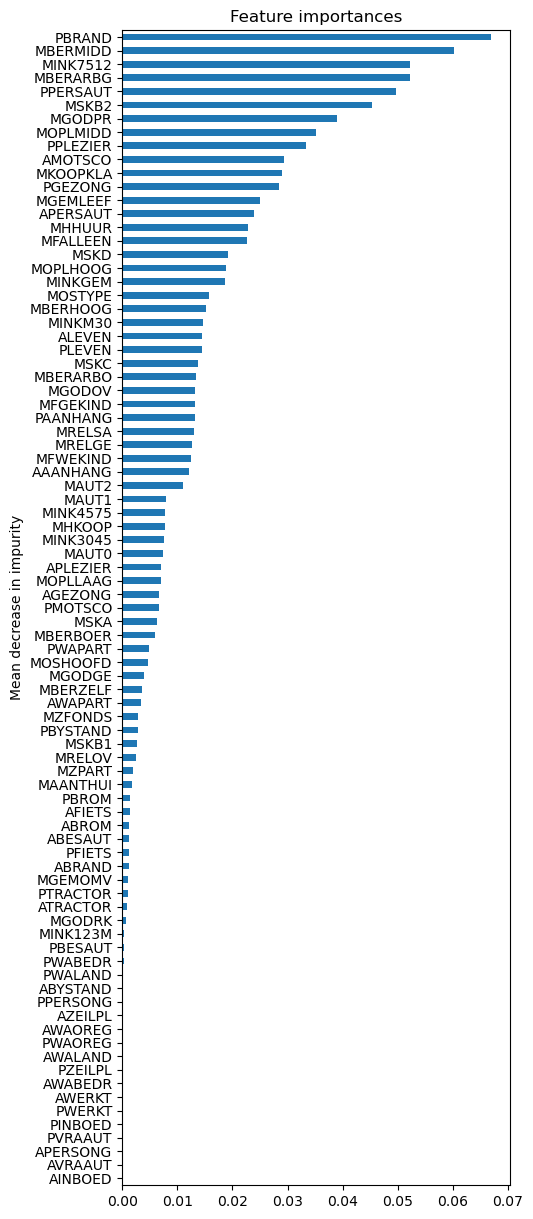

In [63]:
feature_names = X_train_carav.columns.tolist()
feature_importances = pd.Series(boosted_model.feature_importances_, index=feature_names)
fig, ax = plt.subplots(figsize=(5, 15))
feature_importances.sort_values().plot.barh()
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity");

#### Exercise 8.4.11 (c)

Use the boosting model to predict  the response on the test data. Predict that a person will make a purchase if the estimated probability of purchase is greater than $20\%$. Form a confusion matrix. What fraction of the people predicted to make a purchase do in fact make one? How does this compare with the results obtained from applying $\text{KNN}$ or logistic regression to this data set?

In [64]:
y_hat = (boosted_model.predict_proba(X_test_carav)[:, 1] > 0.2).astype(int)

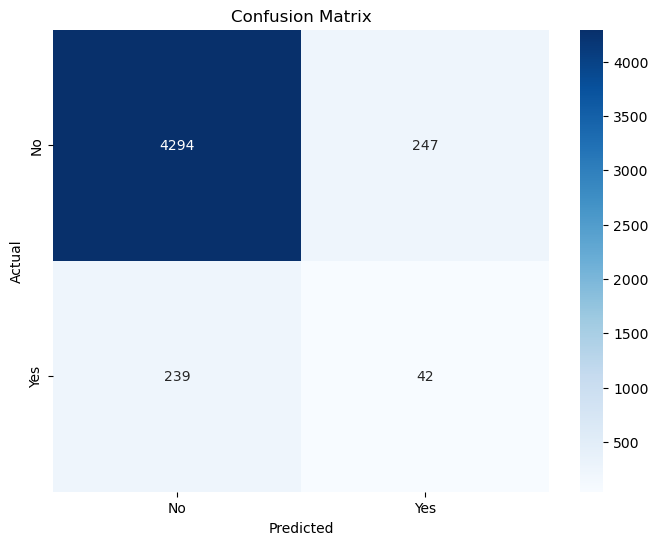

In [65]:
cm = confusion_matrix(y_test_carav, y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(caravan_data.Purchase), yticklabels=np.unique(caravan_data.Purchase))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');


In [66]:
tn, fp, fn, tp = cm.ravel()

In [67]:
precision = tp / (tp + fp)
precision

0.1453287197231834

In [68]:
recall = tp / (tp + fn)
recall

0.1494661921708185

In [69]:
knn = KNeighborsClassifier(n_neighbors=5)

In [70]:
X_train_carav_knn = X_train_carav[['PBRAND', 'MBERMIDD', 'MINK7512', 'MBERARBG', 'PPERSAUT']]
X_test_carav_knn = X_test_carav[['PBRAND', 'MBERMIDD', 'MINK7512', 'MBERARBG', 'PPERSAUT']]

In [71]:
knn.fit(X_train_carav_knn, y_train_carav)

KNeighborsClassifier()

In [72]:
y_hat = (knn.predict_proba(X_test_carav_knn)[:, 1] > 0.2).astype(int)

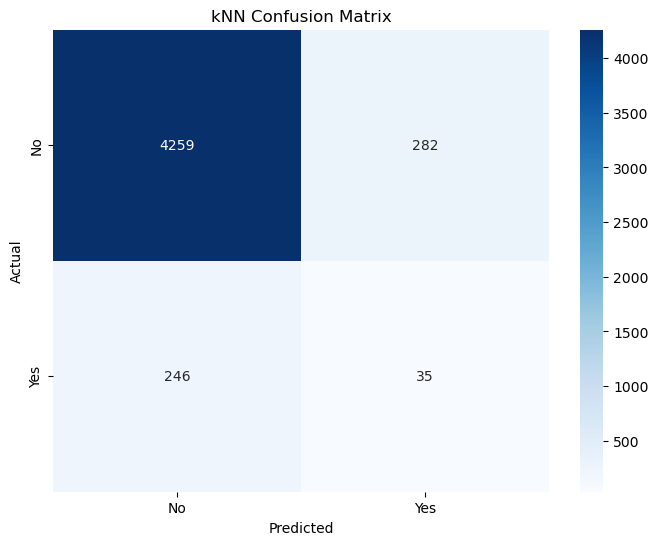

In [73]:
cm = confusion_matrix(y_test_carav, y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(caravan_data.Purchase), yticklabels=np.unique(caravan_data.Purchase))
plt.title('kNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');


In [74]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
precision

0.11041009463722397

In [75]:
recall = tp / (tp + fn)
recall

0.12455516014234876

In [76]:
lr = LogisticRegression()
lr.fit(X_train_carav, y_train_carav)

LogisticRegression()

In [77]:
lr_predict =  (lr.predict_proba(X_test_carav)[:, 1] > 0.2).astype(int)


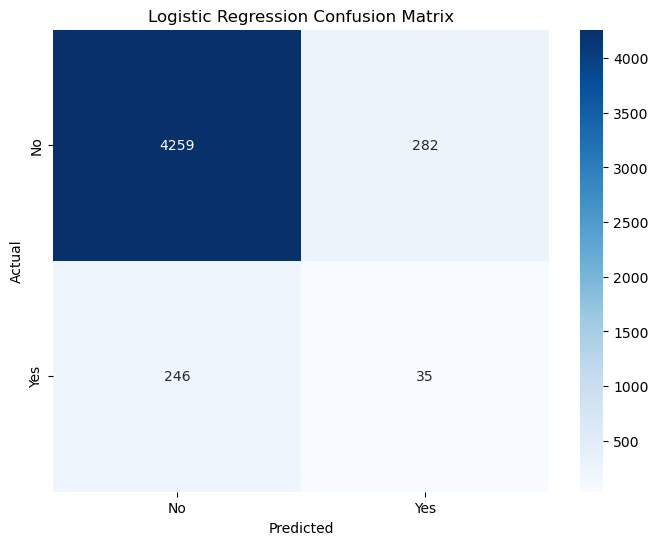

In [78]:
cm = confusion_matrix(y_test_carav, y_hat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(caravan_data.Purchase), yticklabels=np.unique(caravan_data.Purchase))
plt.title('Logistic Regression Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual');


In [79]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
precision

0.11041009463722397

In [80]:
recall = tp / (tp + fn)
recall

0.12455516014234876

#### Exercise 8.4.12 

Apply boosting, bagging, random forests and BART to a data set of your choice. Be sure to fit the models on a training set and to evaluate their performance on the test set. How accurate are the results compared to simple methods like linear or logistic regression? Which of these approaches yields the best performance?

__Answer__:

- the best method is the Random Forest which achieves around $80\%$ of the accuracy,
- Logistic Regression perfroms little worse, despite its simpliness, it achieves $75\%$ on test set, which is also quite good accuracy.

In [81]:
wine = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [82]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [83]:
wine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [84]:
wine['quality_bin'] = pd.cut(wine.quality, bins=2, include_lowest=True, labels=['Low', 'High'])

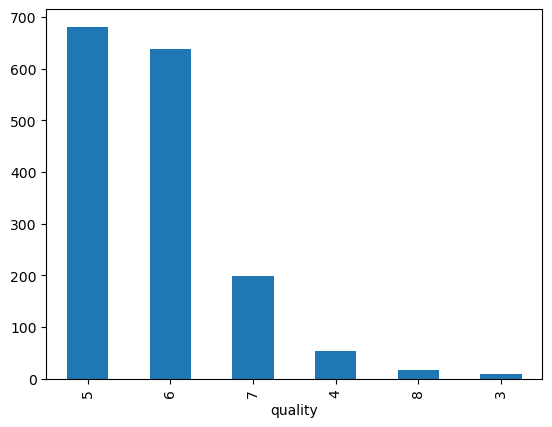

In [85]:
wine.quality.value_counts().plot(kind='bar');

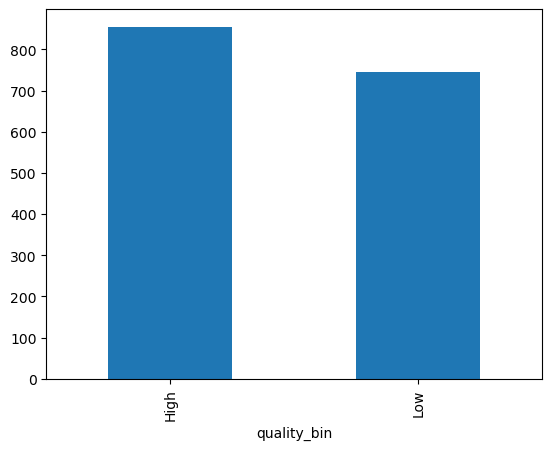

In [86]:
wine.quality_bin.value_counts().plot(kind='bar');

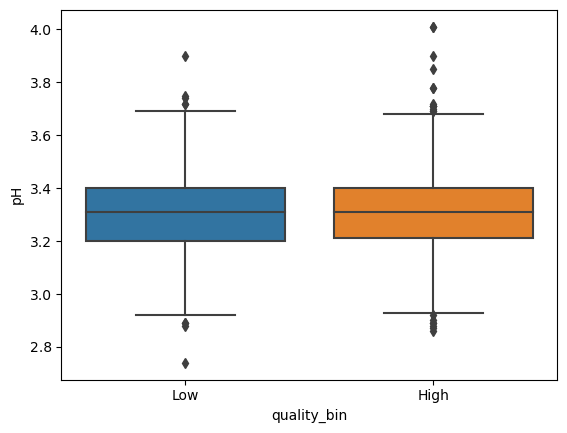

In [87]:
sns.boxplot(x='quality_bin', y='pH', data=wine);

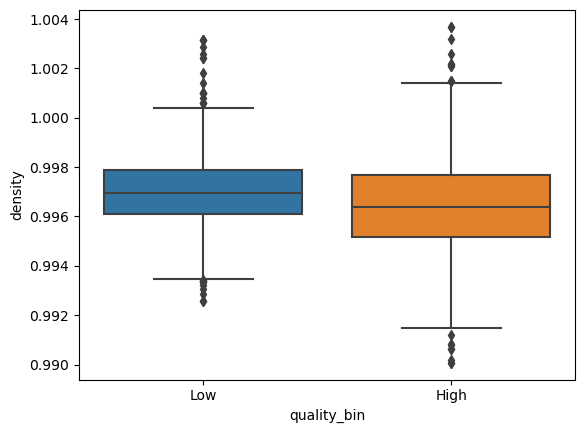

In [88]:
sns.boxplot(x='quality_bin', y='density', data=wine);

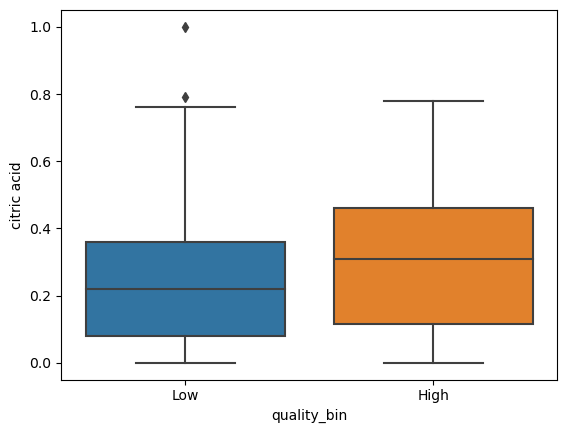

In [89]:
sns.boxplot(y='citric acid', x='quality_bin', data=wine);

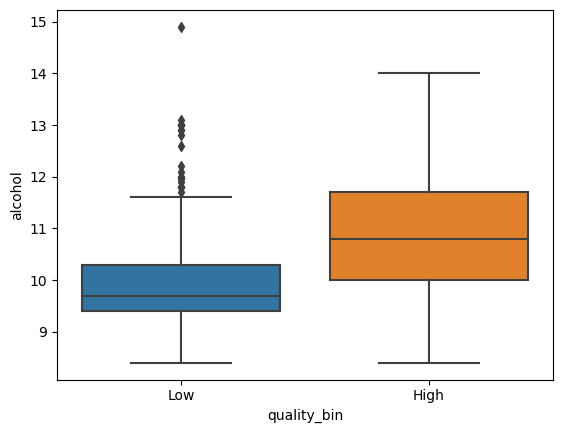

In [90]:
sns.boxplot(y='alcohol', x='quality_bin', data=wine);

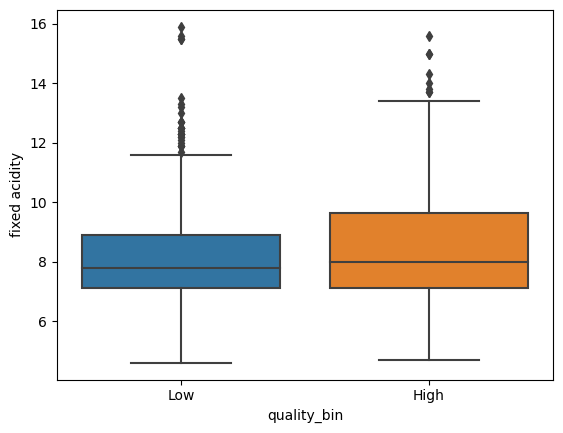

In [91]:
sns.boxplot(y='fixed acidity', x='quality_bin', data=wine);

### Train test split

In [92]:
X, y = wine[wine.columns.drop(['quality', 'quality_bin'])], wine['quality_bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Feature importance

In [93]:
clf = DTC(random_state=0, criterion='entropy', min_samples_leaf=5)

In [94]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5, random_state=0)

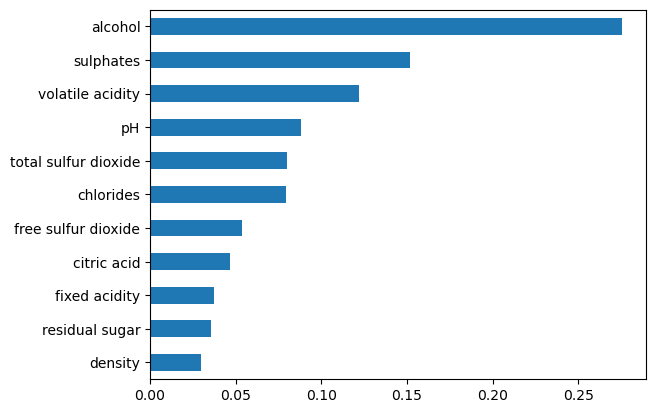

In [95]:
feature_importances = clf.feature_importances_
feature_names = X_train.columns.tolist()

pd.Series(feature_importances, index=feature_names).sort_values().plot(kind='barh');

In [96]:
y_hat = clf.predict(X_test)
acc = np.mean(y_test == y_hat)
acc

0.7083333333333334

In [97]:
ccp_alphas = np.linspace(0, 0.03, 20)

error_rates = []
tree_depths = []
for alpha in ccp_alphas:
    clf = DTC(ccp_alpha=alpha)
    clf.fit(X_train, y_train)
    scores = cross_val_score(clf, X_train, y_train, cv=10)  
    tree_depths.append(clf.tree_.max_depth)
    error_rate = 1 - np.mean(scores)
    error_rates.append(error_rate)

optimal_alpha = ccp_alphas[np.argmin(error_rates)]
final_model = DTC(ccp_alpha=optimal_alpha)
final_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.003157894736842105)

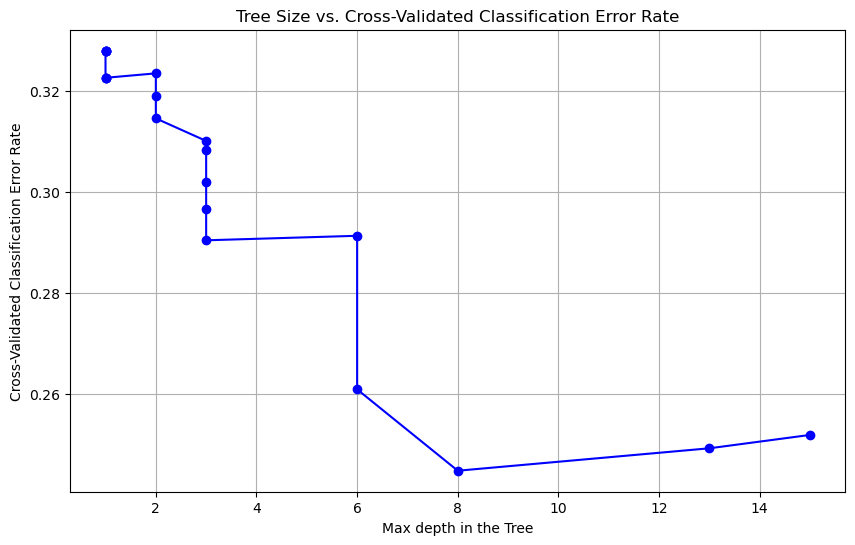

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(tree_depths, error_rates, marker='o', linestyle='-', color='b')
plt.title('Tree Size vs. Cross-Validated Classification Error Rate')
plt.xlabel('Max depth in the Tree')
plt.ylabel('Cross-Validated Classification Error Rate')
plt.grid(True)
plt.show()

In [99]:
accuracy_score(y_test, final_model.predict(X_test))

0.70625

### Boosting

In [100]:
start_rate = 1e-6
end_rate = 1
num_rates = 50
learning_rates = np.logspace(np.log10(start_rate), np.log10(end_rate), num=num_rates)
train_accs = []
test_accs = []

for lr in learning_rates:
    model = GBC(n_estimators=1000, max_depth=5, random_state=0, learning_rate=lr)
    model.fit(X_train, y_train)

    y_hat_train = model.predict(X_train)

    train_acc = accuracy_score(y_train, y_hat_train)
    train_accs.append(train_acc)

    y_hat_test = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_hat_test)
    test_accs.append(test_acc)


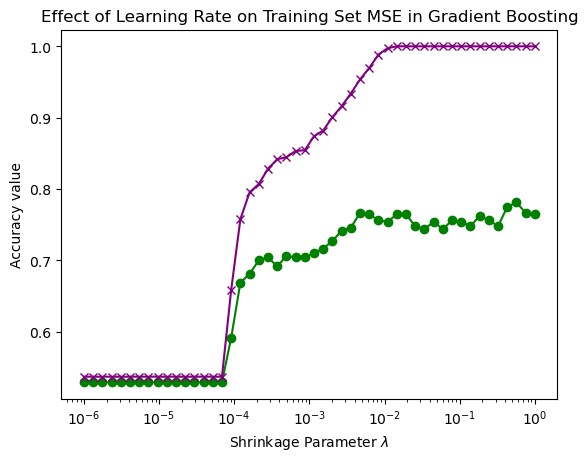

In [101]:
plt.plot(learning_rates, test_accs, marker='o', color='green', label='test accuracy')
plt.plot(learning_rates, train_accs, marker='x', color='purple', label='train accuracy')
plt.xscale('log')
plt.xlabel('Shrinkage Parameter $\lambda$')
plt.ylabel('Accuracy value')
plt.title('Effect of Learning Rate on Training Set MSE in Gradient Boosting')
plt.show()

### Bagging

In [102]:
base_model = DTC(criterion='gini', min_samples_leaf=5, max_depth=5, random_state=0)
bagging_model = BaggingClassifier(base_estimator=base_model, n_jobs=-1, random_state=0, bootstrap_features=True)

In [103]:
bagging_model.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                        min_samples_leaf=5,
                                                        random_state=0),
                  bootstrap_features=True, n_jobs=-1, random_state=0)

In [104]:
test_acc = accuracy_score(y_test, bagging_model.predict(X_test))
test_acc

0.7458333333333333

#### Random Forests


In [105]:
rf = RandomForestClassifier(n_estimators=1000, bootstrap=True, criterion='gini', max_features='log2', n_jobs=-1)
rf.fit(X_train, y_train)

accuracy_score(y_test, rf.predict(X_test))

0.7916666666666666

In [106]:
n_estimators = np.arange(10, 1100, 100)
max_features_values = ['sqrt', 'log2'] + list(range(1, X_train.shape[1] + 1))
test_acc_values = []

for max_features in max_features_values:
    for n_estimator in n_estimators:
        rf_model = RandomForestClassifier(n_estimators=n_estimator, max_features=max_features, random_state=0)
        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)

        test_acc = accuracy_score(y_test, y_pred)
        print(f"Test MSE (max_features={max_features}): {test_acc}")
        test_acc_values.append(test_acc)
        feature_importances = rf_model.feature_importances_
        print(f"Feature Importances (max_features={max_features}):", feature_importances)
        print("-" * 50)
    

Test MSE (max_features=sqrt): 0.75
Feature Importances (max_features=sqrt): [0.05641815 0.10917395 0.06257907 0.0438589  0.07876899 0.04416287
 0.12823941 0.07103427 0.07102418 0.16691773 0.16782247]
--------------------------------------------------
Test MSE (max_features=sqrt): 0.7854166666666667
Feature Importances (max_features=sqrt): [0.06564061 0.10838906 0.0683909  0.05491244 0.06772239 0.06082771
 0.10420487 0.08605223 0.0692925  0.14067766 0.17388963]
--------------------------------------------------
Test MSE (max_features=sqrt): 0.7895833333333333
Feature Importances (max_features=sqrt): [0.06459671 0.11303149 0.06948285 0.05535597 0.0697351  0.06078977
 0.10340004 0.08765413 0.07127948 0.1367701  0.16790435]
--------------------------------------------------
Test MSE (max_features=sqrt): 0.79375
Feature Importances (max_features=sqrt): [0.06610452 0.11335895 0.06721201 0.05586456 0.06944647 0.06103823
 0.10281858 0.08617413 0.07107748 0.13729901 0.16960607]
----------------

#### BART

In [107]:
lec = LabelEncoder()
y_train_enc = lec.fit_transform(y_train)
y_test_enc = lec.transform(y_test)

In [108]:
bart = BART(random_state=0, burnin=10, ndraw=20)

bart.fit(X_train, y_train_enc)

BART(burnin=10, ndraw=20, random_state=0)

In [109]:
# bart.predict(X_test.astype(np.float32)) # throws UFuncTypeError: ufunc 'greater_equal' did not contain a loop with signature matching types

### Logistic Regression

In [110]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [111]:
accuracy_score(y_test, lr.predict(X_test))

0.75